# TRABAJO PRÁCTICO 4 - KNN Y ANÁLISIS DEL DISCRIMINANTE

In [442]:
#librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import pairplot 
from sklearn import model_selection as ms
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score 

# Exploración de datos

(211, 11)
(211,)
3


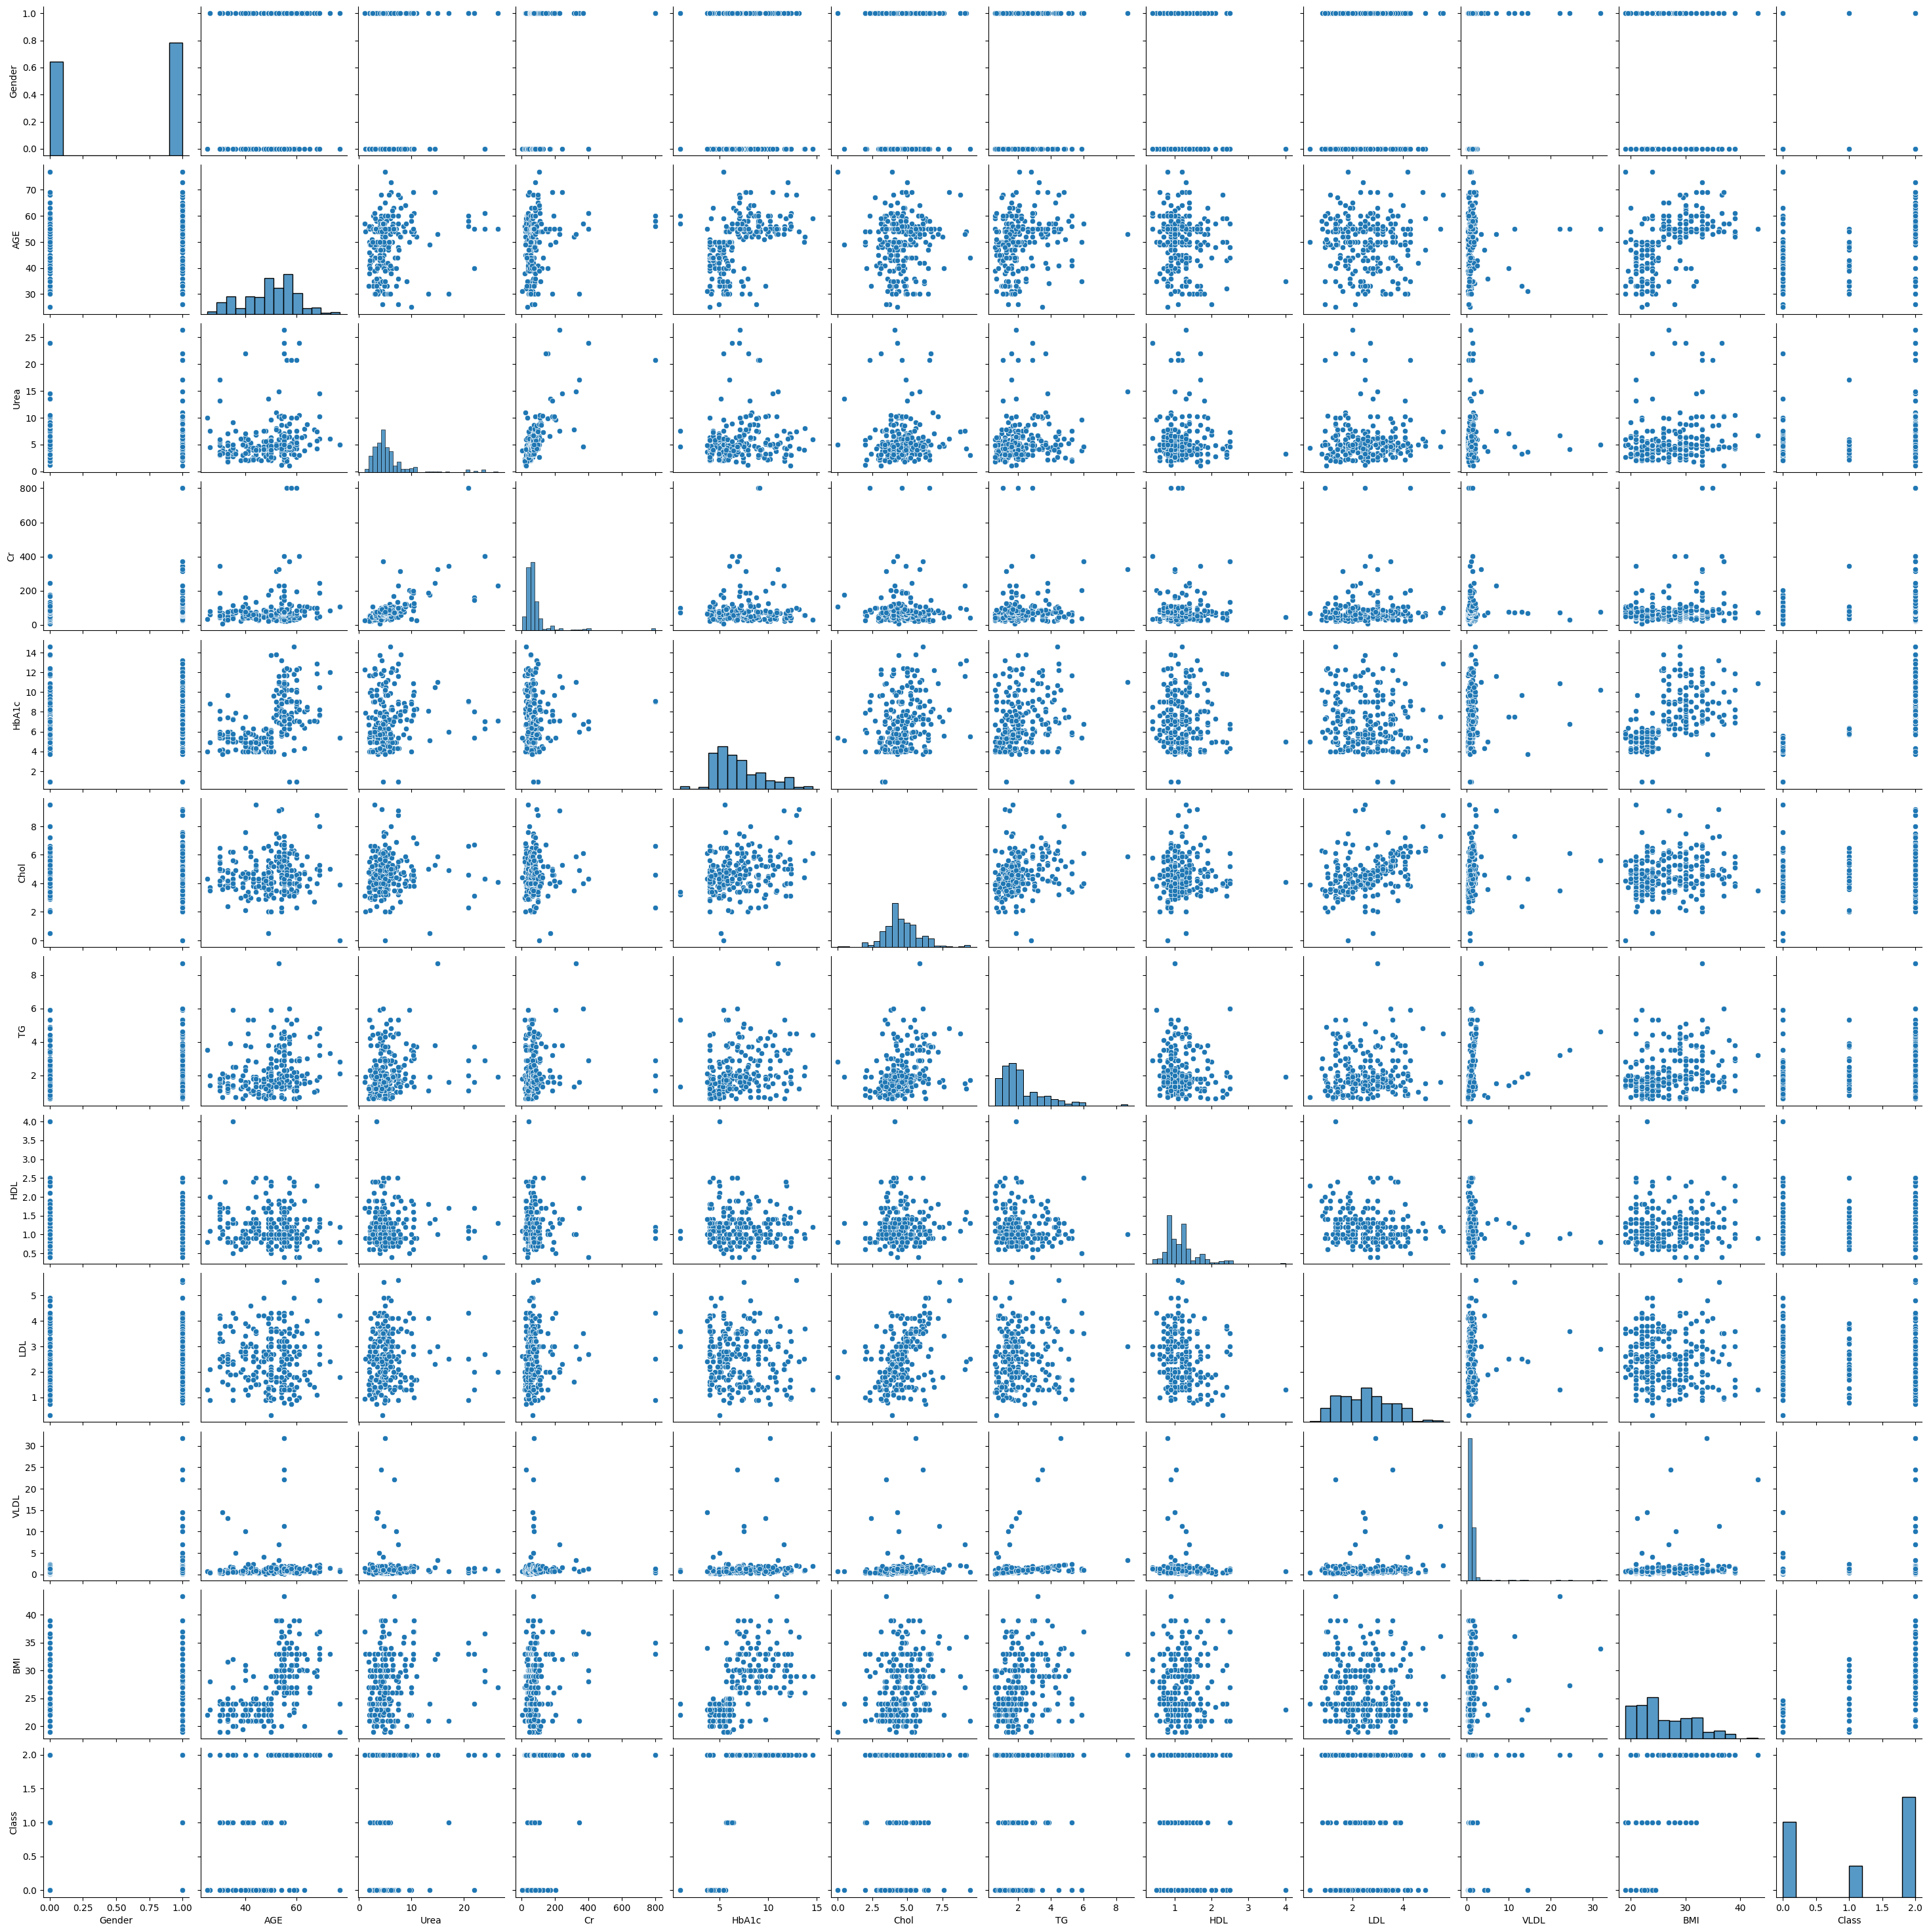

In [443]:
#Se cargan los datos del csv
df = pd.read_csv('MulticlassDiabetesDataset.csv')

p_test = 0.2
p_train = 0.8

#Cantidad de muestras por clase
# print(df.shape[0])

#Gráfico con pairplot
pairplot(df)

#Se definen los conjuntos de entrenamiento y testeo 
[train,test] = ms.train_test_split(df, train_size = p_train ,test_size = p_test)

y_train=train['Class'].sort_index() #Se selecciona el feature de clase y se ordenan los datos
x_train = train.drop(columns = ['Class']).sort_index() #Se elimina el feature 'Class' de los datos de entrenamiento

y_test = test['Class'].sort_index() #Se selecciona el feature de clase y se ordenan los datos
x_test = test.drop(columns = ['Class']).sort_index() #Se elimina el feature 'Class' de los datos de testeo y se ordenan

n_cat = len(np.unique(y_train)) #Se calcula la longitud de la lista con las apariciones únicas en el feature 'Class'

print(x_train.shape)
print(y_train.shape)
print(n_cat)


# Análisis del discriminante

## Se crea la clase LDA_QDA

In [444]:
class LDA_QDA:
    def __init__ (self, LDA = False, n_cat = 0):
        self.LDA = LDA #Se define si se quiere el modelo LDA o QDA
        self.n_cat = n_cat #Se guarda la cantidad de categorías en el problema
        self.D = None #Clasificaciones
        self.c = None #Probabilidades
        self.sigma = None #Matriz de covarianza
        self.sigma_lda = None #Matriz de covarianza para LDA

    #Testeo de entrenamiento
    def fit (self, X, y):
        
        #Se separan las muestras que corresponden a cada categoría en D (D_k)
        self.D = [X[y==i] for i in range(self.n_cat)]

        n_samples = X.shape[0] #Se guarda la cantidad de muestras
        self.c = []
        self.mu = []
        self.sigma = []
        
        if self.LDA == True:
            self.sigma_lda = []

        for i in range(self.n_cat):
            #Se calculan las constantes para cada conjunto
            self.c.append( self.D[i].shape[0]/n_samples )

            #Se calcula la media de cada categoría en cada feature
            self.mu.append(np.mean(self.D[i], axis=0).reshape(-1))

            #Se calcula sigma para cada categoría
            diff = self.D[i] - self.mu[i]
            self.sigma.append( np.atleast_2d( (1/(self.D[i].shape[0]-1)) * diff.T @ diff ) )

            #Se calcula el sigma que se utiliza en el método LDA para cada categoría
            if self.LDA == True:
                self.sigma_lda.append( np.atleast_2d( (1/(n_samples-self.n_cat)) * (self.D[i].shape[0] -1 ) * self.sigma[i] ) )
        
        if self.LDA == True:
            self.sigma_lda = np.atleast_2d( np.sum(self.sigma_lda,axis = 0) ) #Se calcula el sigma resultante para utilizar en LDA tras el calculo por categorías
            
        # print(len(self.sigma))
        # print(self.sigma_lda[0].shape)
        # print(self.D[0].shape)
        # print(len(self.mu))
        # print(self.D[0].shape)
        # print(self.D[1].shape)
        # print(self.D[2].shape)
        
        
    # #Testeo soft
    def predict_prob (self, X):
        delta = self.predict_discriminant(X)
        exp_delta = np.exp(delta)
        pred_soft = exp_delta / np.sum(exp_delta, axis=1, keepdims=True) #Se calcula la predicción soft, cuidando de hacer la suma en cada fila de forma correcta
        return pred_soft
        

    # #Testeo hard
    def predict (self, X):
        delta = self.predict_discriminant(X)
        pred_hard = np.argmax(delta,axis=1)
        return pred_hard


    #Alternativa práctica para el testeo soft
    def predict_discriminant(self, X):
        
        if hasattr(X, "values"):
            x = X.values
        else:
            x = np.array(X)

        if x.ndim == 1:
            x = x.reshape(-1, 1)
            
            
        delta = np.zeros((x.shape[0], self.n_cat)) #Se crea un array de los deltas de n_muestras x n_categorias
        if self.LDA == True:  
            inv_sigma_lda = np.linalg.inv(self.sigma_lda) #Se calcula la inversa de la matriz sigma para evitar repetir cálculos
            for j in range(x.shape[0]): #Se calcula el discriminante en cada x, en las n_cat
                for i in range(self.n_cat):
                    delta[j,i] = np.log(self.c[i]) + x[j,:].T @ inv_sigma_lda @ self.mu[i] - 0.5 * self.mu[i].T @ inv_sigma_lda @ self.mu[i]
            
        else: 
            for j in range(x.shape[0]): #Se calcula el discriminante para cada muestra en las n features, usando QDA
                for i in range(self.n_cat):
                    diff = x[j,:]-self.mu[i] #Se calcula la diferencia para cada muestra en las n categorías para evitar repetir cálculos
                    delta[j,i] = np.log(self.c[i]) - (0.5) * diff.T @ np.linalg.inv(self.sigma[i]) @ (diff) - 0.5 * np.log(np.linalg.det(self.sigma[i]))
            
        return delta

## Comparación de LDA y QDA para 1 feature

LDA: 
 accuracy = 0.8490566037735849 
 f1_macro = 0.5963499731615673


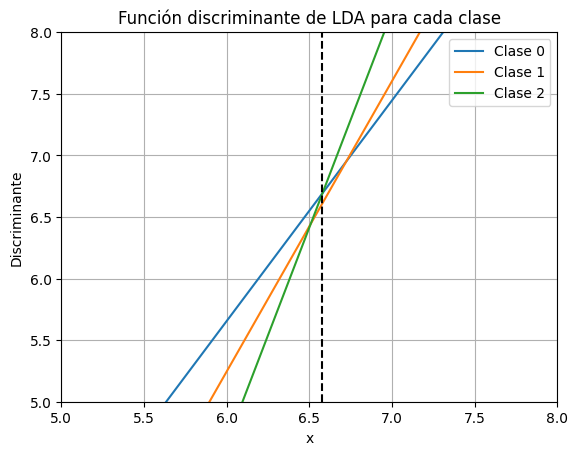

QDA: 
 accuracy = 0.9245283018867925 
 f1_macro = 0.9202464202464201


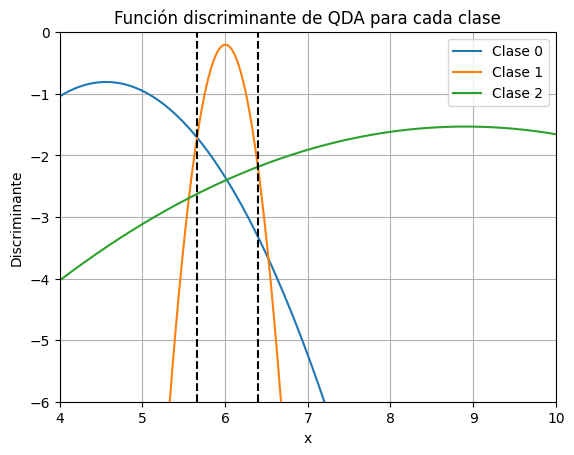

In [445]:
#Se selecciona el feature 'HbA1c' para entrenar el modelo y para las predicciones
selected_feature_train = np.array(x_train['HbA1c'])
# selected_feature_train = selected_feature_train.reshape(-1,1) #Se lo convierte en vector columna 

selected_feature_test = np.array(x_test['HbA1c'])
# selected_feature_test = selected_feature_test.reshape(-1,1) #Se lo convierte en vector columna

#------------------------------------------- LDA
model_lda = LDA_QDA(LDA = True, n_cat = 3)

model_lda.fit(selected_feature_train,y_train)

#Se calcula el mínimo y el máximo de los valores de test
x_min, x_max = selected_feature_test.min()-1, selected_feature_test.max()+1
x_graph = np.linspace(x_min, x_max, 2000).reshape(-1,1) #Se obtiene un array de x para graficar el discriminante

y_pred_graph = model_lda.predict(x_graph.reshape(-1,1)) #Se obtiene la hard predict para las muestras utilizadas en el gráfico
index = np.where(np.diff(y_pred_graph) != 0)[0] #Se buscan los índices donde se cruzan los discriminantes (valores de la frontera)
x_edge = x_graph[index] #Se asignan las muestras de la frontera

y_pred = model_lda.predict(selected_feature_test)
#Se obtiene el accuracy
accuracy = accuracy_score(y_test, y_pred)

#Se obtiene la matriz de confusión
c_matrix = confusion_matrix(y_test, y_pred)

#Se obtiene la macro-F1
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f'LDA: \n accuracy = {accuracy} \n f1_macro = {f1_macro}')

#Se obtiene la función discriminante
delta = model_lda.predict_discriminant(x_graph)

plt.figure()
#Se grafica la función discriminante
for i in range(delta.shape[1]):
    plt.plot(x_graph, delta[:,i], label=f"Clase {i}")

#Se grafica la frontera de decisión
for x_e in x_edge:
    plt.axvline(x_e, color='k', linestyle='--')

plt.xlabel('x')
plt.ylabel('Discriminante')
plt.legend()
plt.title('Función discriminante de LDA para cada clase')
plt.xlim([5,8])
plt.ylim([5,8])
plt.grid()
plt.show()






#------------------------------------------- QDA

#Entrenamiento
model_qda = LDA_QDA(n_cat = 3)

model_qda.fit(selected_feature_train,y_train)

#Se calcula el mínimo y el máximo de los valores de test
x_min, x_max = selected_feature_test.min()-1, selected_feature_test.max()+1
x_graph = np.linspace(x_min, x_max, 2000).reshape(-1,1) #Se obtiene un array de x para graficar el discriminante


y_pred_graph = model_qda.predict(x_graph.reshape(-1,1)) #Se obtiene la hard predict para las muestras utilizadas en el gráfico
index = np.where(np.diff(y_pred_graph) != 0)[0] #Se buscan los índices donde se cruzan los discriminantes (valores de la frontera)
x_edge = x_graph[index] #Se asignan las muestras de la frontera


y_pred = model_qda.predict(selected_feature_test)
#Se obtiene el accuracy
accuracy = accuracy_score(y_test, y_pred)

#Se obtiene la matriz de confusión
c_matrix = confusion_matrix(y_test, y_pred)

#Se obtiene la macro-F1
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f'QDA: \n accuracy = {accuracy} \n f1_macro = {f1_macro}')

#Se obtiene la función discriminante
delta = model_qda.predict_discriminant(x_graph)

plt.figure()
#Se grafica la función discriminante
for i in range(delta.shape[1]):
    plt.plot(x_graph, delta[:,i],label=f"Clase {i}")

#Se grafica la frontera de decisión
for x_e in x_edge:
    plt.axvline(x_e, color='k', linestyle='--')

plt.xlabel('x')
plt.ylabel('Discriminante')
plt.legend()
plt.title('Función discriminante de QDA para cada clase')
plt.xlim([4,10])
plt.ylim([-6,0])
plt.grid()
plt.show()

##### Sobre la frontera de decisión y el discriminante

Se puede apreciar que LDA clasifica principalmente en las clases 0 y 2, pero prácticamente no hace predicciones sobre la clase 1.

Por otro lado, QDA contempla las 3 clases en distintos rangos, por lo que tiene sentido pensar que se ajusta mejor a los datos, dado que hay 3 clases en los mismos. Sin embargo, es importante notar que la clase 1 tiene un rango acotado con respecto a las demás.

##### Sobre el Accuracy y el Macro-F1

En el caso de LDA, el accuracy y el F1 possen valores distintos.
Eso se debe a que el modelo tiene buena predicción para las clases que predice: Clase 0 y Clase 2, por ello el accuracy que mide la cantidad de aciertos totales con respecto a la cantidad de valores reales, da un valor alto. Pero por otro lado, el Macro-F1 contempla realmente la precisión en la predicción sobre cada clase, es decir, hace un promedio de las predicciones de cada clase y al ser la Clase 1 ignorada, entonces dicho promedio baja y es por eso que discrepan estos parámetros.

Para el caso de QDA, el accuracy es más alto que en el caso de LDA, esto principalmente se debe a que hay una clase no ignorada, generando que la cantidad de aciertos predichos totales con respecto a la totalidad de los valores reales, sean más altos. Por otro lado, esto mismo se denota en Macro-F1, ya que en este se realiza el promedio de las precisiones para cada clase y dado que ninguna de ellas es ignorada, el parámetro Macro-F1 es más alto que en LDA y es similar al accuracy de QDA, por ser el promedio de las precisiones.

## Comparación de LDA y QDA para 2 features

LDA: 
 accuracy = 0.8301886792452831 
 f1_macro = 0.5898277276456111


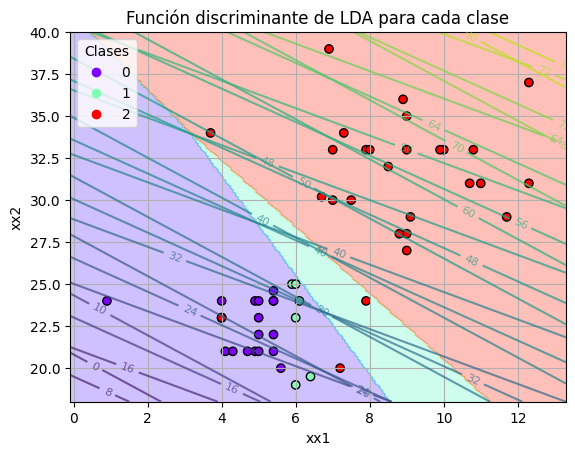

LDA: 
 accuracy = 0.9622641509433962 
 f1_macro = 0.9705513784461153


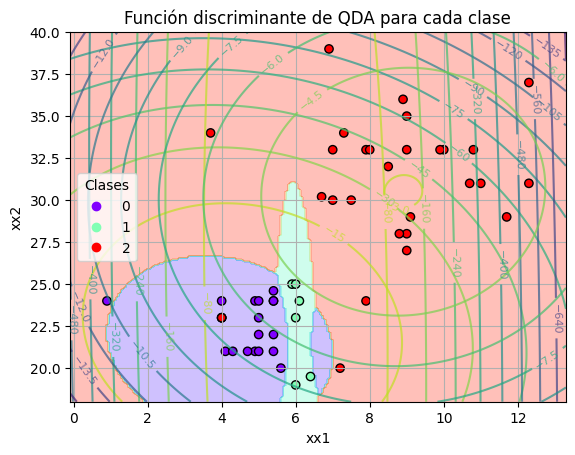

In [446]:
#Se selecciona el feature 'HbA1c' y 'BMI' para entrenar el modelo y para las predicciones
selected_feature_train = np.array(x_train[['HbA1c', 'BMI']])

selected_feature_test = np.array(x_test[['HbA1c', 'BMI']])

#------------------------------------------- LDA
model_lda = LDA_QDA(LDA = True, n_cat = 3)

model_lda.fit(selected_feature_train,y_train)

#Se calcula el mínimo y el máximo de los valores de test para cada feature
x1_min, x1_max = selected_feature_test[:,0].min() - 1, selected_feature_test[:,0].max() + 1
x2_min, x2_max = selected_feature_test[:,1].min() - 1, selected_feature_test[:,1].max() + 1
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 200),
                       np.linspace(x2_min, x2_max, 200)) #Se crea la grilla de x para graficar el discriminante en 2D
grid_points = np.c_[xx1.ravel(), xx2.ravel()] #Se ajusta la grilla a la forma (#muestras, 2), es decir, como 2 vectores columna concatenados

y_pred_graph = model_lda.predict(grid_points) #Se obtiene la hard predict para las muestras utilizadas en el gráfico
y_pred_graph = y_pred_graph.reshape(xx1.shape) #Se ajusta el tamaño del vector para tener el mismo shape que las columnas de la grilla

y_pred = model_lda.predict(selected_feature_test) #Predicción de los valores reales del test
#Se obtiene el accuracy
accuracy = accuracy_score(y_test, y_pred)

#Se obtiene la matriz de confusión
c_matrix = confusion_matrix(y_test, y_pred)

#Se obtiene la macro-F1
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f'LDA: \n accuracy = {accuracy} \n f1_macro = {f1_macro}')

#Se obtiene la función discriminante
delta = model_lda.predict_discriminant(grid_points)

plt.figure()
#Se grafican las fronteras de decisión y las muestras originales con su pertenencia a cada clase
plt.contourf(xx1, xx2, y_pred_graph, alpha=0.3, cmap='rainbow')
scatter = plt.scatter(selected_feature_test[:,0], selected_feature_test[:,1], c=y_test, edgecolor='k', cmap = 'rainbow')

for i in range(delta.shape[1]): #Se grafican las curvas de nivel de la función discriminante
    d = delta[:, i].reshape(xx1.shape)
    cl= plt.contour(xx1, xx2, d, levels=10, alpha=0.7)
    plt.clabel(cl, inline=True, fontsize=8)

plt.legend(*scatter.legend_elements(), title="Clases")
plt.xlabel('xx1')
plt.ylabel('xx2')
plt.title('Función discriminante de LDA para cada clase')
plt.grid()
plt.show()






#------------------------------------------- QDA

#Entrenamiento
model_qda = LDA_QDA(n_cat = 3)

model_qda.fit(selected_feature_train,y_train)

#Se calcula el mínimo y el máximo de los valores de test para cada feature
x1_min, x1_max = selected_feature_test[:,0].min() - 1, selected_feature_test[:,0].max() + 1
x2_min, x2_max = selected_feature_test[:,1].min() - 1, selected_feature_test[:,1].max() + 1
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 200),
                       np.linspace(x2_min, x2_max, 200)) #Se crea la grilla de x para graficar el discriminante en 2D
grid_points = np.c_[xx1.ravel(), xx2.ravel()] #Se ajusta la grilla a la forma (#muestras, 2), es decir, como 2 vectores columna concatenados

y_pred_graph = model_qda.predict(grid_points) #Se obtiene la hard predict para las muestras utilizadas en el gráfico
y_pred_graph = y_pred_graph.reshape(xx1.shape) #Se ajusta el tamaño del vector para tener el mismo shape que las columnas de la grilla

y_pred = model_qda.predict(selected_feature_test) #Predicción de los valores reales del test
#Se obtiene el accuracy
accuracy = accuracy_score(y_test, y_pred)

#Se obtiene la matriz de confusión
c_matrix = confusion_matrix(y_test, y_pred)

#Se obtiene la macro-F1
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f'LDA: \n accuracy = {accuracy} \n f1_macro = {f1_macro}')

#Se obtiene la función discriminante
delta = model_qda.predict_discriminant(grid_points)

plt.figure()
#Se grafican las fronteras de decisión y las muestras originales con su pertenencia a cada clase
plt.contourf(xx1, xx2, y_pred_graph, alpha=0.3, cmap='rainbow')
scatter = plt.scatter(selected_feature_test[:,0], selected_feature_test[:,1], c=y_test, edgecolor='k', cmap = 'rainbow')

for i in range(delta.shape[1]): #Se grafican las curvas de nivel de la función discriminante
    d = delta[:, i].reshape(xx1.shape)
    cl= plt.contour(xx1, xx2, d, levels=10, alpha=0.7)
    plt.clabel(cl, inline=True, fontsize=8)

plt.legend(*scatter.legend_elements(), title="Clases")
plt.title('Función discriminante de QDA para cada clase')
plt.xlabel('xx1')
plt.ylabel('xx2')
plt.grid()
plt.show()

##### Análisis comparativo de los métodos para 2 features.

En el caso de los 2 features, LDA sigue teniendo el problema de la clasificación para la clase 1. Es evidente que las muestras reales, no caen dentro de la zona de la clase 1, sino en la zona de la clase 0 y esto es producto de prácticamente ignorar dicha clase, al igual que antes. Esto mismo se refleja en el accuracy menor al de QDA: este tiene menor precisión total y a su vez, la macro-F1 denota que la media de las precisiones es inferior, sugiriendo nuevamente que una de ellas tiene baja precisión, la clase 1 como se evidencia en los gráficos.

Por otro lado, para QDA ocurre algo similar al caso de 1 feature. Se tiene que las muestras de la clase 1, se encuentran en la zona de decisión de dicha clase, indicando que no se ignora la misma, y lo mismo se refleja nuevamente en el aumento del accuracy y del macro-F1. Además, es importante notar que agregar este feature, no mejora significativamente el accuracy ni el macro-F1.

## Comparación de LDA y QDA para todos los features

In [447]:
#Se utilizan todos los features para el entrenamiento y las predict
selected_feature_train = np.array(x_train)

selected_feature_test = np.array(x_test)

#------------------------------------------- LDA
model_lda = LDA_QDA(LDA = True, n_cat = 3)

model_lda.fit(selected_feature_train,y_train)

y_pred = model_lda.predict(selected_feature_test) #Se obtiene la Predicción de los valores reales del test

#Se obtiene el accuracy
accuracy = accuracy_score(y_test, y_pred)

#Se obtiene la matriz de confusión
c_matrix = confusion_matrix(y_test, y_pred)

#Se obtiene la macro-F1
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f'LDA: \n accuracy = {accuracy} \n f1_macro = {f1_macro}')



#------------------------------------------- QDA

#Entrenamiento
model_qda = LDA_QDA(n_cat = 3)

model_qda.fit(selected_feature_train,y_train)

y_pred = model_qda.predict(selected_feature_test) #Se realiza la Predicción de los valores reales del test
#Se obtiene el accuracy
accuracy = accuracy_score(y_test, y_pred)

#Se obtiene la matriz de confusión
c_matrix = confusion_matrix(y_test, y_pred)

#Se obtiene la macro-F1
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f'LDA: \n accuracy = {accuracy} \n f1_macro = {f1_macro}')

LDA: 
 accuracy = 0.8113207547169812 
 f1_macro = 0.7172161172161173
LDA: 
 accuracy = 0.9245283018867925 
 f1_macro = 0.9170653907496013


##### Análisis de QDA y LDA para todos los features

El fenómeno sigue siendo el mismo, en LDA hay una diferencia entre accuracy y f1_macro, producto de ignorar la clase 1.

Por otro lado, el accuracy general bajó, esto se debe a que el resto de features agregados, realmente meten ruido al sistema, en vez de ayudar en la predicción, la perjudican.

# Vecinos más cercanos (KNN)

## Se crea la clase KNN

In [448]:
def __init__ (self):

def fit(self, X, y): 

#Soft
def predict_proba(self, X):

#Hard
def predict(self, X):

IndentationError: expected an indented block after function definition on line 1 (1592297648.py, line 3)